In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Part 1 - Summary Statistics and Plots

In [2]:
# Read data from file
df = pd.read_csv('summer_internship_takehome.csv')

In [3]:
# Calculate profits and profit margins
df['Profit'] = df['Gross revenue'] - df['Fixed cost'] - df['Variable cost'] - df['Rental cost']
df['Profit margin'] = df['Profit'] / df['Gross revenue']

In [4]:
df

,Location number,Month,State,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,Profit,Profit margin
0,1,1,TX,48628171.02,9218156.69,24278189.23,365880,4452,False,14765945.10,0.303650
1,1,2,TX,48107179.24,10587747.35,25116844.41,365880,4452,False,12036707.48,0.250206
2,1,3,TX,64352278.29,10193873.77,33703499.83,365880,4452,False,20089024.69,0.312173
3,1,4,TX,45943677.96,8764165.00,24037719.47,365880,4452,False,12775913.49,0.278078
4,1,5,TX,32761434.98,8022116.43,16432119.18,365880,4452,False,7941319.37,0.242398
...,...,...,...,...,...,...,...,...,...,...,...
3991,333,8,TX,56295415.57,10711406.46,29142010.15,286920,4478,False,16155078.96,0.286970
3992,333,9,TX,63512936.32,12675148.57,32346778.80,286920,4478,False,18204088.95,0.286620
3993,333,10,TX,54062593.50,9784913.45,28299846.81,286920,4478,False,15690913.24,0.290236
3994,333,11,TX,48903414.85,10638082.89,25285040.20,286920,4478,False,12693371.76,0.259560


In [5]:
# Calculate mean and median profit margins by location
df_profit_summaries = df.groupby('Location number').agg({'Profit margin':['mean','median']})

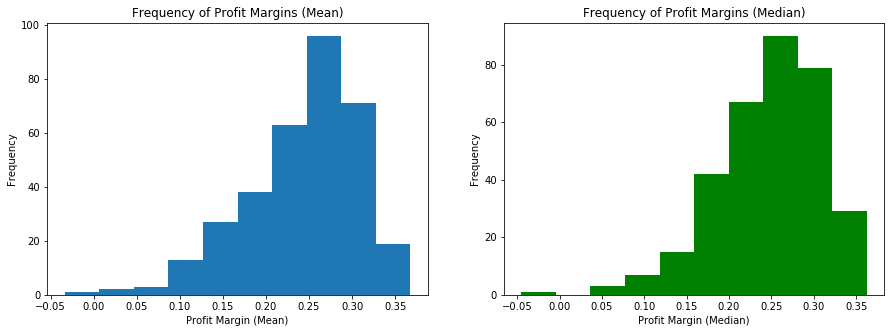

In [6]:
# Visualize distribution of mean and median profit margins
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(df_profit_summaries[('Profit margin','mean')])
ax[0].set_xlabel('Profit Margin (Mean)')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Frequency of Profit Margins (Mean)')

ax[1].hist(df_profit_summaries[('Profit margin','median')], color='green')
ax[1].set_xlabel('Profit Margin (Median)')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Frequency of Profit Margins (Median)')

plt.show()

### Does the profit margin across locations appear normally distributed?
Profit margin across locations does not quite appear normally distributed. Normal distributions are unimodal and symmetric about the mean and median of the distribution, which should be the same value if Normal. In other words, the tails of a Normal distribution should be roughly the same. The distribution of profit margins, though unimodal, appears to exhibit a left skew, meaning that the mean is greater than the median and the left tail is longer than the right tail.

In [7]:
# Calculate monthly and quarterly aggregate revenue
df_agg_revenue_monthly = df.groupby('Month').agg({'Gross revenue':'sum'})
df_agg_revenue_quarterly = [sum(df_agg_revenue_monthly.loc[i:i+2]['Gross revenue']) for i in [1, 4, 7, 10]]

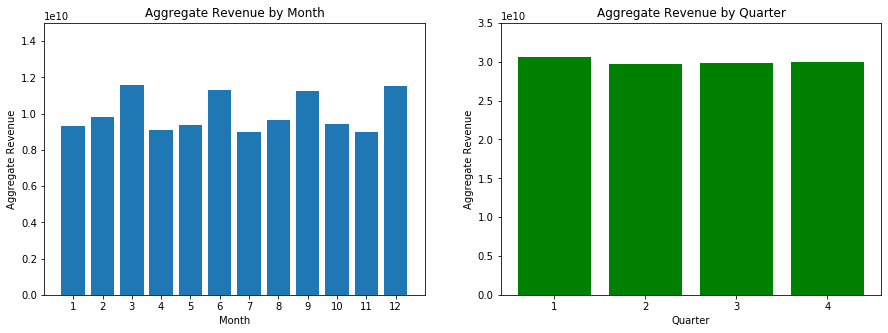

In [8]:
# Visualize monthly and quarterly aggregate revenue
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].bar(np.arange(1, 13, 1), df_agg_revenue_monthly['Gross revenue'])
ax[0].set_ylim(0, 1.5 * 10**10)
ax[0].set_xticks(np.arange(1, 13, 1))
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Aggregate Revenue')
ax[0].set_title('Aggregate Revenue by Month')

ax[1].bar(np.arange(1, 5, 1), df_agg_revenue_quarterly, color='green')
ax[1].set_ylim(0, 3.5 * 10**10)
ax[1].set_xticks(np.arange(1, 5, 1))
ax[1].set_xlabel('Quarter')
ax[1].set_ylabel('Aggregate Revenue')
ax[1].set_title('Aggregate Revenue by Quarter')

plt.show()

Aggregate revenue appears to follow a predictable 3-month cycle, with months 3, 6, 9, and 12 generating more revenue than the other months. Since the period of the cycle is roughly 3 months, aggregate revenue by quarter is relatively stable.

# Part 2 - Cleaning the Data

In [9]:
# Group data by location, split data based on whether rental cost is known or unknown,
# and standardize values in dataframe
df_by_location = df.groupby('Location number').agg({'State':'max', 'Gross revenue':'mean',
                                                    'Fixed cost':'mean', 'Variable cost':'mean',
                                                    'Rental cost':'mean', 'Number of products':'mean',
                                                    'Owned':'max'})

df_by_location = pd.get_dummies(df_by_location, columns=['State'], drop_first=True)
df_known, df_unknown = df_by_location[df_by_location['Owned'] == False], df_by_location[df_by_location['Owned']]
X_known, y_known = df_known.drop(['Rental cost', 'Owned'], axis=1), df_known['Rental cost']

scaler = StandardScaler().fit(X_known)
X_known_standardized = scaler.transform(X_known)

In [10]:
# Use cross validation to fit regularized linear models for imputing missing rental costs
alphas = np.logspace(-4, 4, 100)

impute_model_ridge = RidgeCV(alphas).fit(X_known_standardized, y_known)
impute_model_lasso = LassoCV(alphas=alphas, max_iter=100000).fit(X_known_standardized, y_known)

known_pred_ridge = impute_model_ridge.predict(X_known_standardized)
known_pred_lasso = impute_model_lasso.predict(X_known_standardized)

cv_ridge = cross_val_score(impute_model_ridge, X_known_standardized, y_known)
cv_lasso = cross_val_score(impute_model_lasso, X_known_standardized, y_known)

print('R^2 for known data (Ridge):', r2_score(y_known, known_pred_ridge))
print('Cross validation scores (Ridge):', cv_ridge)
print('Cross validation mean (Ridge):', cv_ridge.mean())

print('\nR^2 for known data (Lasso):', r2_score(y_known, known_pred_lasso))
print('Cross validation scores (Lasso):', cv_lasso)
print('Cross validation mean (Lasso):', cv_lasso.mean())

R^2 for known data (Ridge): 0.6002400302792177
Cross validation scores (Ridge): [0.27787649 0.58623512 0.4877004  0.60851738 0.58570192]
Cross validation mean (Ridge): 0.5092062618663499

R^2 for known data (Lasso): 0.6020541691648746
Cross validation scores (Lasso): [0.27156796 0.58506542 0.45999872 0.56782978 0.60034435]
Cross validation mean (Lasso): 0.49696124641483747


In [11]:
# Use Ridge model (which performed better during cross validation) to impute rental costs on standardized data
# from owned locations
X_unknown_standardized = scaler.transform(df_unknown.drop(['Rental cost', 'Owned'], axis=1))
df_unknown['Rental cost'] = np.round(impute_model_ridge.predict(X_unknown_standardized), 2)

C:\Users\alexl\Anaconda3\envs\cs109b\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [12]:
# Rebuild dataframe with imputed rental costs
df_imputed = df.copy()
df_imputed['Rental cost'] = df.apply(lambda x: df_unknown.loc[x['Location number']]['Rental cost'] 
                                     if x['Owned'] else x['Rental cost'], axis=1)
df_imputed['Profit'] = df_imputed['Gross revenue'] - df_imputed['Fixed cost'] - \
                       df_imputed['Variable cost'] - df_imputed['Rental cost']
df_imputed['Profit margin'] = df_imputed['Profit'] / df_imputed['Gross revenue']

In [13]:
df_imputed[df_imputed['Owned']]

,Location number,Month,State,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,Profit,Profit margin
24,3,1,IL,30791018.69,6123108.00,17948338.14,92455.25,4620,True,6627117.30,0.215229
25,3,2,IL,23805331.16,5014361.53,13051817.38,92455.25,4620,True,5646697.00,0.237203
26,3,3,IL,33916624.99,6043273.71,19190769.99,92455.25,4620,True,8590126.04,0.253272
27,3,4,IL,24170582.83,5196755.17,13505396.58,92455.25,4620,True,5375975.83,0.222418
28,3,5,IL,24925332.00,4688566.82,14531349.44,92455.25,4620,True,5612960.49,0.225191
...,...,...,...,...,...,...,...,...,...,...,...
3871,323,8,IL,22194100.42,4586590.51,11232409.36,86107.43,4664,True,6288993.12,0.283363
3872,323,9,IL,22690822.00,5672584.18,10676641.22,86107.43,4664,True,6255489.17,0.275684
3873,323,10,IL,22318237.77,4834736.44,11101511.95,86107.43,4664,True,6295881.95,0.282096
3874,323,11,IL,19412797.72,4899314.22,9351323.91,86107.43,4664,True,5076052.16,0.261480


# Part 3 - Quantify Drivers of Success

In [14]:
# Aggregate data by location, allowing us to work with locations rather than location/month combinations
agg_dict = {'State':'max', 'Gross revenue':'mean', 'Fixed cost':'mean', 'Variable cost':'mean', 'Rental cost':'mean',
            'Number of products':'mean', 'Owned':'max', 'Profit':'mean', 'Profit margin':'mean'}
df_imputed_by_location = df_imputed.groupby('Location number').agg(agg_dict)

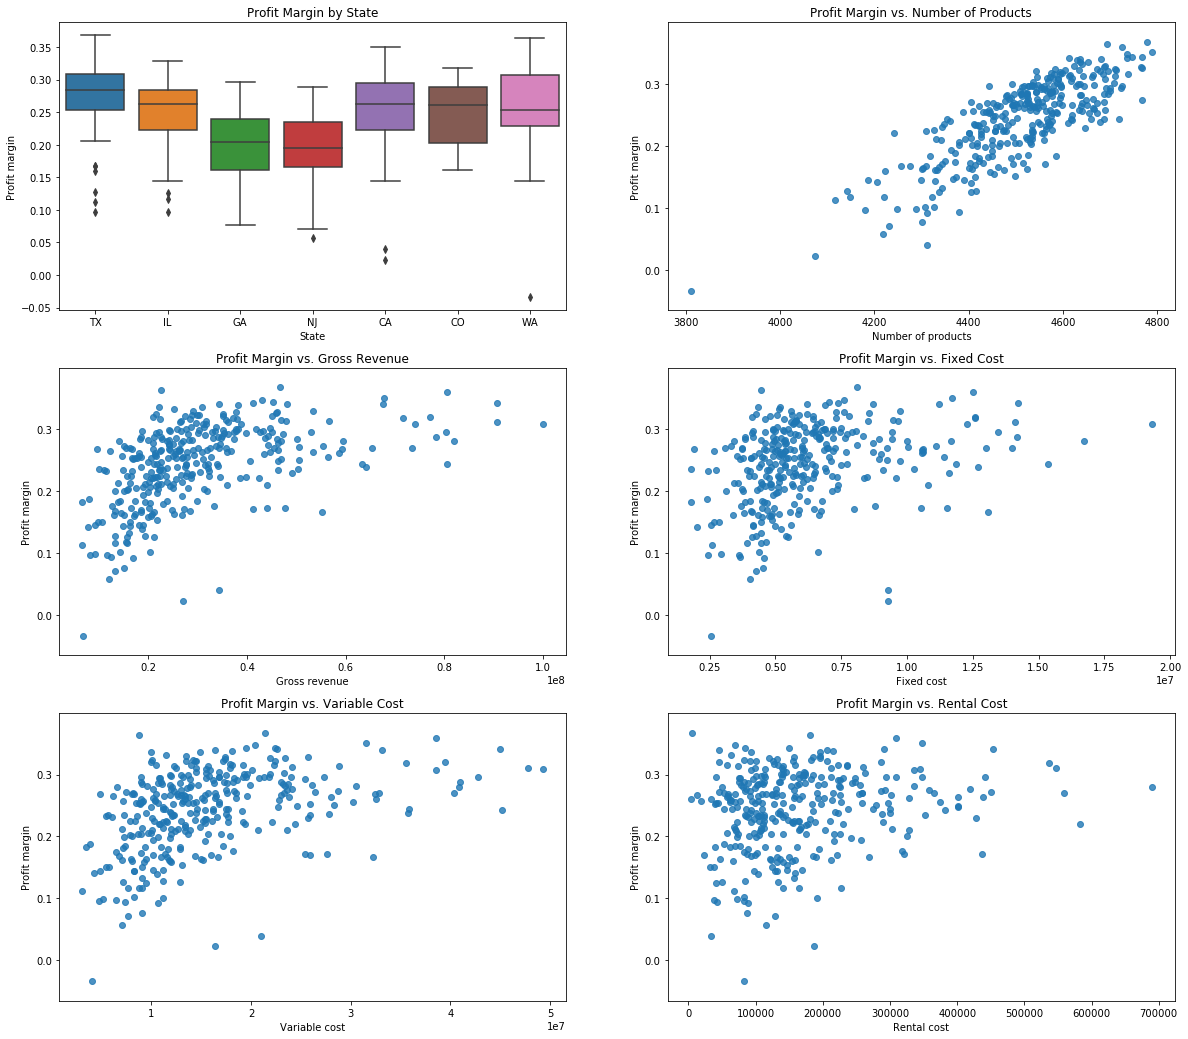

In [15]:
# Visualize relationships between potential predictors and profit margin
fig, ax = plt.subplots(3, 2, figsize=(20, 18))

sns.boxplot(x='State', y='Profit margin', ax=ax[0][0], data=df_imputed_by_location).set_title('Profit Margin by State')

ax[0][1].scatter(df_imputed_by_location['Number of products'], df_imputed_by_location['Profit margin'], alpha=0.8)
ax[0][1].set_xlabel('Number of products')
ax[0][1].set_ylabel('Profit margin')
ax[0][1].set_title('Profit Margin vs. Number of Products')

ax[1][0].scatter(df_imputed_by_location['Gross revenue'], df_imputed_by_location['Profit margin'], alpha=0.8)
ax[1][0].set_xlabel('Gross revenue')
ax[1][0].set_ylabel('Profit margin')
ax[1][0].set_title('Profit Margin vs. Gross Revenue')

ax[1][1].scatter(df_imputed_by_location['Fixed cost'], df_imputed_by_location['Profit margin'], alpha=0.8)
ax[1][1].set_xlabel('Fixed cost')
ax[1][1].set_ylabel('Profit margin')
ax[1][1].set_title('Profit Margin vs. Fixed Cost')

ax[2][0].scatter(df_imputed_by_location['Variable cost'], df_imputed_by_location['Profit margin'], alpha=0.8)
ax[2][0].set_xlabel('Variable cost')
ax[2][0].set_ylabel('Profit margin')
ax[2][0].set_title('Profit Margin vs. Variable Cost')

ax[2][1].scatter(df_imputed_by_location['Rental cost'], df_imputed_by_location['Profit margin'], alpha=0.8)
ax[2][1].set_xlabel('Rental cost')
ax[2][1].set_ylabel('Profit margin')
ax[2][1].set_title('Profit Margin vs. Rental Cost')

plt.show()

Based on exploratory data analysis, it appears as though stores in GA and NJ have lower profit margins than those in other states, with stores in TX having higher profit margins. Also, there appears to be a positive correlation between number of products offered at a location and profit margin. Gross revenue and costs do not appear to have a noteworthy correlation with profit margin.

In [16]:
# Fit a linear model to predict profit margin using number of products
x, y = sm.add_constant(df_imputed_by_location['Number of products']), df_imputed_by_location['Profit margin']

profit_model = sm.OLS(endog=y, exog=x, hasconst=True).fit()
print(profit_model.summary())

                            OLS Regression Results                            
Dep. Variable:          Profit margin   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     625.2
Date:                Sun, 05 Jul 2020   Prob (F-statistic):           3.04e-78
Time:                        21:28:18   Log-Likelihood:                 614.67
No. Observations:                 333   AIC:                            -1225.
Df Residuals:                     331   BIC:                            -1218.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.5095      0

Fitting a linear model to predict profit margin using only number of products, we see that there is a fairly strong correlation ($R^2=0.65$) between the two. Using the coefficient from the model, we can predict that increasing the number of products offered at a location by 25 will lead to an increase in profit margin of roughly 0.01 (or 1%).

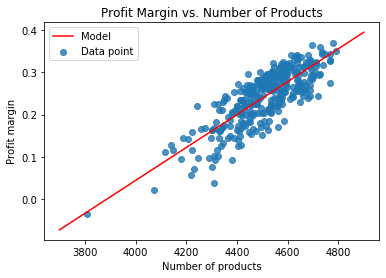

In [17]:
# Plot model output against data points
x_range = np.linspace(3700, 4900, 1000)

plt.scatter(df_imputed_by_location['Number of products'], df_imputed_by_location['Profit margin'], 
            alpha=0.8, label='Data point')
plt.plot(x_range, profit_model.predict(sm.add_constant(x_range)), label='Model', c='r')
plt.xlabel('Number of products')
plt.ylabel('Profit margin')
plt.title('Profit Margin vs. Number of Products')
plt.legend()

plt.show()

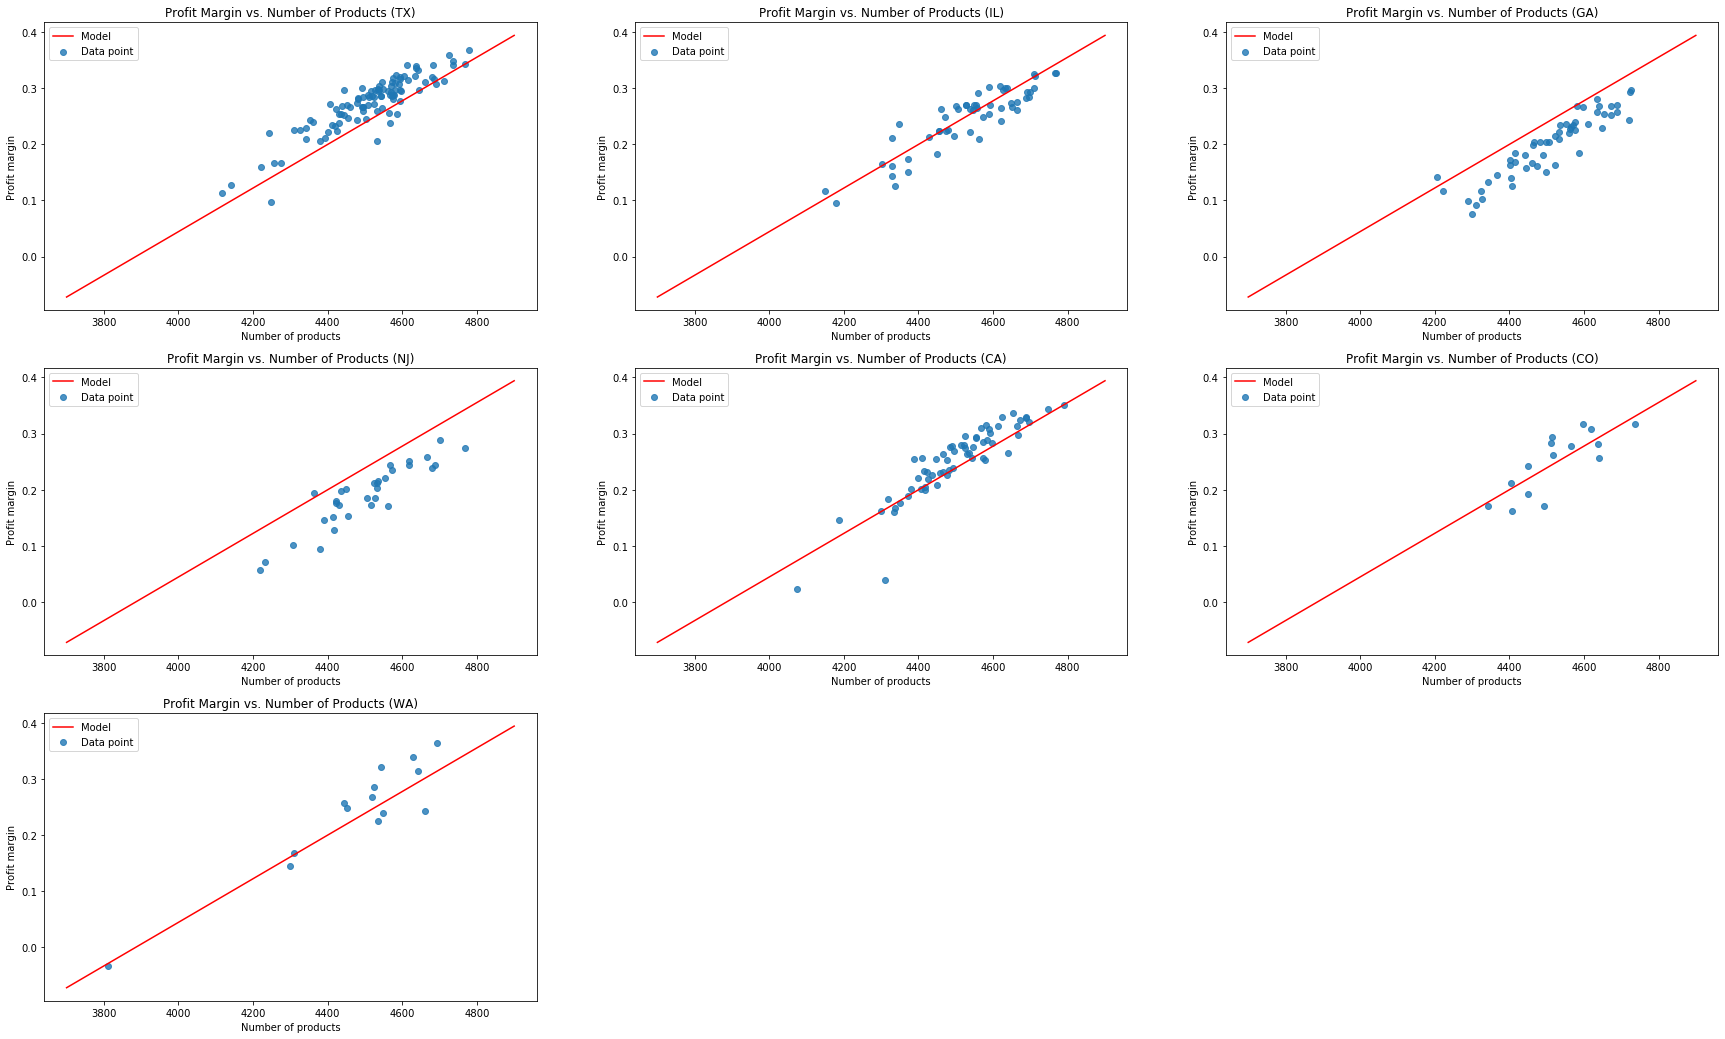

In [18]:
# Visualize the relationship of profit margin to number of products, stratified by state
states = df['State'].unique()

fig, ax = plt.subplots(3, 3, figsize=(30, 18))

for i, state in enumerate(states):
    current_df = df_imputed_by_location[df_imputed_by_location['State'] == state]
    ax[i // 3][i % 3].scatter(current_df['Number of products'], current_df['Profit margin'], 
                              alpha=0.8, label='Data point')
    ax[i // 3][i % 3].plot(x_range, profit_model.predict(sm.add_constant(x_range)), label='Model', c='r')
    ax[i // 3][i % 3].set_xlabel('Number of products')
    ax[i // 3][i % 3].set_ylabel('Profit margin')
    ax[i // 3][i % 3].set_title(f'Profit Margin vs. Number of Products ({state})')
    ax[i // 3][i % 3].legend()
    
fig.delaxes(ax[2][1])
fig.delaxes(ax[2][2])
 
plt.show()

Based on these graphs, we can see that locations in GA and NJ seem to underperform in terms of profit margin as compared to the expected value for a given number of products. The red line represents the expected profit margin for a given number of products (as determined by the linear model we fit previously), and profit margins for locations in NJ and GA consistently fall below this line. In contrast, locations in TX and, to a lesser extent, CA appear to generally fall above this line, meaning that profit margins for locations in these states tend to be higher. Profit margins for the remaining states appear to trace the line quite closely.

In [19]:
# Calculate the intercept adjustments necessary to minimize mean squared error per state
adjustments = {}
test_adj = np.arange(-0.1, 0.1, 0.001)
mses = []

for state in states:
    current_df = df_imputed_by_location[df_imputed_by_location['State'] == state]
    current_pred = profit_model.predict(sm.add_constant(current_df['Number of products']))
    best_mse = float('inf')
    for adj in test_adj:
        curr_mse = mean_squared_error(current_df['Profit margin'], current_pred+adj)
        mses.append(curr_mse)
        if curr_mse < best_mse:
            adjustments[state] = round(adj, 4)
            best_mse = curr_mse

In [20]:
adjustments

{'TX': 0.03,
 'IL': -0.005,
 'GA': -0.042,
 'NJ': -0.049,
 'CA': 0.013,
 'CO': 0.001,
 'WA': 0.014}

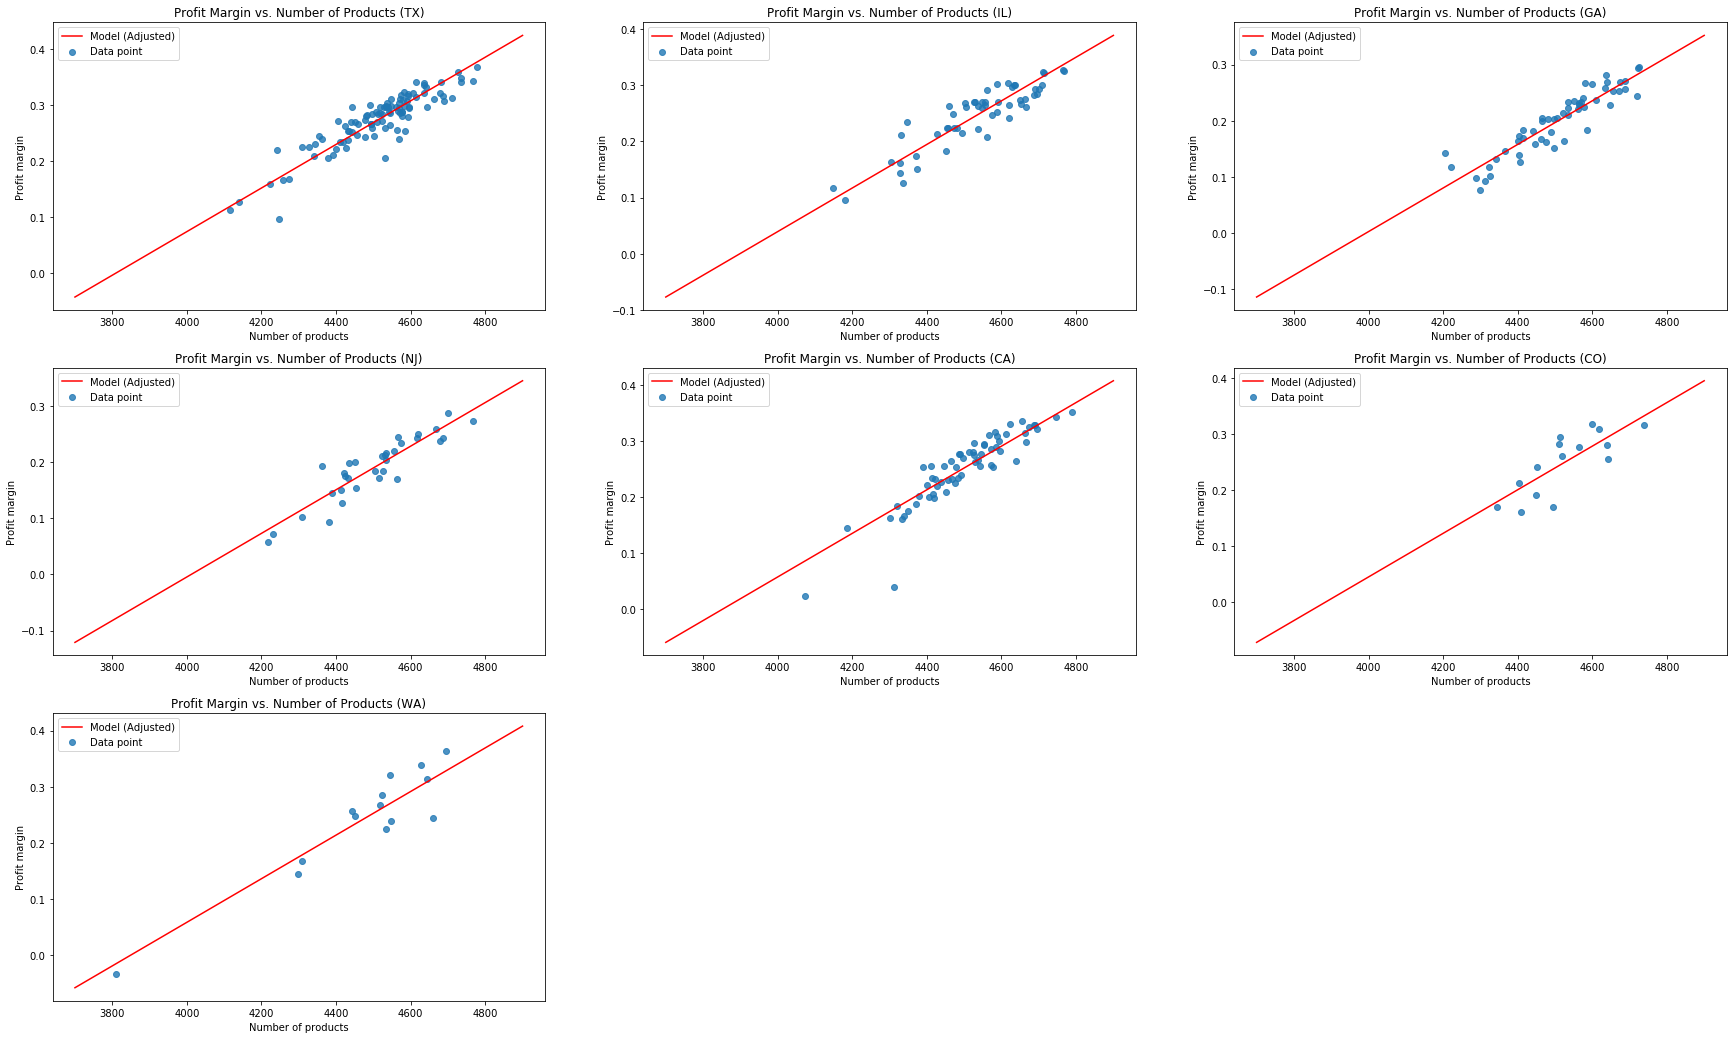

In [21]:
# Visualize the relationship of profit margin to number of products, stratified and adjusted by state
fig, ax = plt.subplots(3, 3, figsize=(30, 18))

for i, state in enumerate(states):
    current_df = df_imputed_by_location[df_imputed_by_location['State'] == state]
    ax[i // 3][i % 3].scatter(current_df['Number of products'], current_df['Profit margin'], 
                              alpha=0.8, label='Data point')
    ax[i // 3][i % 3].plot(x_range, profit_model.predict(sm.add_constant(x_range))+adjustments[state], 
                           label='Model (Adjusted)', c='r')
    ax[i // 3][i % 3].set_xlabel('Number of products')
    ax[i // 3][i % 3].set_ylabel('Profit margin')
    ax[i // 3][i % 3].set_title(f'Profit Margin vs. Number of Products ({state})')
    ax[i // 3][i % 3].legend()
    
fig.delaxes(ax[2][1])
fig.delaxes(ax[2][2])
 
plt.show()

The relationships here seemed quite simple and evident to the naked eye, with the slope appearing relatively constant across states. As such, I opted to fix the slope of the model and minimize mean squared error by changing the intercept, thus determining the effect that different states have on profit margins.

Alternatively, we could fit individual models to each state, with separate slopes and intercepts for each model. I decided against using this approach in this scenario because the effect of increasing the number of products at a location seemed relatively constant across states, and I wanted to focus on isolating the impact of a location being in a particular state.

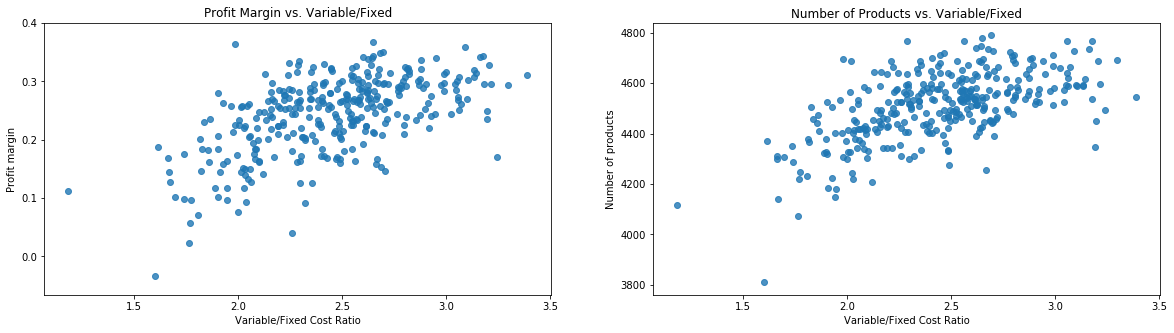

In [22]:
# Plot model output against data points
df_imputed_by_location['Variable/Fixed'] = (df_imputed_by_location['Variable cost'] / 
                                            df_imputed_by_location['Fixed cost'])

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].scatter(df_imputed_by_location['Variable/Fixed'], df_imputed_by_location['Profit margin'], alpha=0.8)
ax[0].set_xlabel('Variable/Fixed Cost Ratio')
ax[0].set_ylabel('Profit margin')
ax[0].set_title('Profit Margin vs. Variable/Fixed')

ax[1].scatter(df_imputed_by_location['Variable/Fixed'], df_imputed_by_location['Number of products'], alpha=0.8)
ax[1].set_xlabel('Variable/Fixed Cost Ratio')
ax[1].set_ylabel('Number of products')
ax[1].set_title('Number of Products vs. Variable/Fixed')

plt.show()

Though it also appears that the variable/fixed cost ratio is correlated to profit margin, plotting number of products against the variable/fixed ratio suggests that increases in profit margin based on increasing variable/fixed ratios can likely be attributed to increasing number of products instead (which we already know has a relatively strong positive correlation with profit margin).

### Email to CEO

Dear CEO,

I hope you are safe, healthy, and doing well. We recently analyzed the dataset you sent over, and I wanted to share a couple of key insights that we believe can help you maximize your profit margins.

First and foremost, stores that carry a higher number of products often yield higher profit margins. Our preliminary models suggest that increasing the number of products in a store by 25 would result in a 0.01 (or 1%) increase in profit margin. As such, if your aim is to maximize margins, increasing the number of products offered at your locations  across the country would likely be an effective strategy.

Second, profit margins tend to vary across states. Locations in NJ and GA tend to have lower profit margins, about 0.04-0.05 (4%-5%) lower than what would be expected based on the national data. On the other hand, locations in TX (and to lesser extents, CA and WA) tend to have higher margins, with TX's margins around 0.03 (3%) higher than the national average. Based on these findings, closing locations in NJ and GA while opening new ones in TX and CA may help increase profit margins nationwide.

In summary, the data would suggest that increasing the number of products offered at your locations while subsituting locations in NJ and GA with locations in TX and CA would increase profit margins nationwide. Please let me know if you have any questions regarding the analysis or any requests regarding further analysis.

Best,  
Alex